# Data Analysis Report

## Preface

#### Scope

Before diving in, it's _vital_ to define and limit the scope of the data and information we want to leverage for this project. 

This is an exciting challenge and there's tons of features that can be derived from the various data sources available with a game such as League of Legends.

For instance, we could incrementally keep building on this leveraging 3rd party sources like the [LeaguePedia](https://lol.fandom.com/wiki/League_of_Legends_Esports_Wiki) API to gather more up-to-date team/game data as it is happening now, or use Riot's own league APIs to extract insights about the meta for every patch within a time-period and adjust weights for strong items, champions, etc. backfilling missing game data and delving into things as deep as needed.

![](doc-assets/tons_of_data.jpg)

However, with a Full-time job and other life-commitments, I've decided to limit the scope to using only the data provided. So, with that said, let's dive right in!

#### Approach

We'll begin by understanding the different data we are provided — applying an EDA (Exploratory Data Analysis) approach, taking a look into the bits and pieces that we will need, derive patterns and gain structure. 

Eventually, we'll harness standout features that will help us develop an algorithm that can contribute towards predicting a team's ranking, and ability to win a game. 

Since the good folks at Riot & AWS gave us Athena Ready™ scripts that we can use to query (the significantly more) compressed data, directly from the S3 bucket without downloading files, I'll be leveraging a combination of utilizing AWS Athena, Glue, and S3 to setup crawlers, buckets, and instances tagged with the `power-rankings-hackathon` key and `2023` value, and of course, Python + frameworks and libraries highlighted within this report.

***
## Leagues

We first need to see the shape of the leagues data, and then determine what information is relevant for us. Thankfully, AWS Athena was quite helpful in the initial Exploration phase of the EDA framework. A general query like 

```sql
SELECT * FROM "lol"."leagues" limit 10;
```

was able to help with understanding such columns and getting rid of the redundant ones like `displayPriority`, `sport` (which is always `lol`), `image` etc. 

All in all, it seems that we have tournament data for 38 leagues hosted across the world.

We want to keep the ID of the league, the name, slug, and of course, all the tournaments within each league so let's create a new dataset which only contains all of the above, for our own ease of use in the future.

In [1]:
%matplotlib inline
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [102]:
with open("../esports-data/lol-esports-data/leagues.json", 'r') as f:
    leagues_data = json.load(f)

league_df_list = []
total_tournaments = 0

for league in leagues_data:
    league_id = league['id']
    league_name = league['name']
    league_slug = league['slug']
    tournaments = [tournament['id'] for tournament in league['tournaments']]
    total_tournaments += len(tournaments)
    df_league = pd.DataFrame({
        'League ID': league_id,
        'League Name': league_name,
        'League Slug': league_slug,
        'Tournaments': [tournaments]
    })
    league_df_list.append(df_league)
    
print("total tournaments from leagues:", total_tournaments)
df_league_tournaments = pd.concat(league_df_list, ignore_index=True)
df_league_tournaments

total tournaments from leagues: 318


,League ID,League Name,League Slug,Tournaments
0,98767991299243165,LCS,lcs,"[110303581083678395, 109517090066605615, 10820..."
1,109511549831443335,LCS Challengers,north_american_challenger_league,"[110574243270525539, 109518697660746274]"
2,109518549825754242,LCS Challengers Qualifiers,lcs_challengers_qualifiers,"[110894544221659776, 110733838935136200, 11042..."
3,107898214974993351,College Championship,college_championship,[107898708099217418]
4,98767991332355509,CBLOL,cblol-brazil,"[110413046183015975, 109523641416750631, 10821..."
5,98767991310872058,LCK,lck,"[110909366079472439, 110371551277508787, 10962..."
6,98767991355908944,LCL,lcl,"[107417471555810057, 106269769724268826, 10566..."
7,105709090213554609,LCO,lco,"[109675608880518030, 109675619694467439, 10819..."
8,98767991302996019,LEC,lec,"[110848560874526298, 110429332688604205, 10991..."
9,98767991349978712,LJL,ljl-japan,"[110395308894756789, 109710208772220245, 10823..."


In [97]:
id_to_slug_map = df_league_tournaments[['League ID', 'League Slug']]
id_to_slug_map.to_json("../esports-data/created/id_to_slug.json", orient="split", index=False)

##### Created Data

In [137]:
# df_league_tournaments.to_csv("../esports-data/created/updated-leagues.csv", index=False)

> NOTE: From here onwards, we will be using `updated-leagues.csv` for league to tournament mappings. All data that is created from cleaning and analyzing will be housed within `esports-data/created`

***
## Players & Teams

For starters, we are given `players.json`, `teams.json`, and digging into S3 we also find `unfiltered_players.json` and `unfiltered_teams.json`. 

In this case, the filtered data refers to players and teams directly affiliated with the LOL pro-scene, since going through some of the sample data within the `unfiltered_player` dataset gives us info of players such as: 
```json
{
    "player_id": "107742456385056460",
    "handle": "cauanzin",
    "first_name": "Cauan",
    "last_name": "Pereira",
    "home_team_id": "107745125595754895"
},
{
    "player_id": "108748906912431580",
    "handle": "shroud",
    "first_name": "Michael",
    "last_name": "Grzesiek",
    "home_team_id": null
},
```
where `cauanzin` is a professional [Valorant player](https://liquipedia.net/valorant/Cauanzin) for LOUD and `shroud` is a [former pro-player](https://liquipedia.net/valorant/Shroud) within the Valorant ecosystem, with his last game in 2022 for Sentinels.

Similarly, `unfiltered_teams` contains LOL unaffiliated teams, for e.g.
```json
{
    "team_id": "111006791685855925",
    "name": "NASR Ignite",
    "acronym": "NASR",
    "slug": "nasr-ignite"
}
```
which is specifically a [Valorant team](https://liquipedia.net/valorant/NASR_Ignite).

Thus, in order to avoid any further data-sanity checks, we will rely on `players` and `teams` files as source of truth for teams and players that are guaranteed to exist within the league of legends eco-system.

Looking into the players and teams data we notice that the players file has a `home_team_id` field for the player, while the teams data comes with `team_id` which this directly maps to. Before we being the mapping process, let's first check of any inconsistencies with our data and whether we can remediate them.

### Problem 1: Data cleaning

Let's check for any missing values, duplicate records, or mismatched data types with both files

In [171]:
# Load the players and teams data
players_df = pd.read_json("../esports-data/additional/players.json")
teams_df = pd.read_json("../esports-data/additional/teams.json")
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222 entries, 0 to 4221
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     4222 non-null   int64  
 1   handle        4222 non-null   object 
 2   first_name    4222 non-null   object 
 3   last_name     4222 non-null   object 
 4   home_team_id  2871 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 165.0+ KB


In [172]:
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   team_id  674 non-null    int64 
 1   name     674 non-null    object
 2   acronym  674 non-null    object
 3   slug     674 non-null    object
dtypes: int64(1), object(3)
memory usage: 21.2+ KB


It seems that while we have 4222 players, only about 2871 have a `home_team_id` value. Whereas, all teams information seems sound so far with no null values. We will want to tackle the problem of missing information as a sub-problem later, but let's continue on-wards and look for duplicates...

In [173]:
players_duplicates_df = players_df[players_df.duplicated(keep=False)]
teams_duplicates_df = teams_df[teams_df.duplicated(keep=False)]

players_duplicates_df, teams_duplicates_df

(               player_id     handle first_name last_name  home_team_id
 2446  100174547541438672  Abbedagge      Felix     Braun  1.013838e+17
 2447  100174547541438672  Abbedagge      Felix     Braun  1.013838e+17
 2448  100174547541438672  Abbedagge      Felix     Braun  1.013838e+17,
                team_id name acronym slug
 72   98767991860392496  TSM     TSM  tsm
 103  98767991860392496  TSM     TSM  tsm)

We have a couple of repeated elements from both datasets. Since we can action on this, let's go ahead and remove duplicates and keep a single entity intact.

In [174]:
players_df = players_df.drop_duplicates().reset_index(drop=True)
teams_df = teams_df.drop_duplicates().reset_index(drop=True)
players_df.shape, teams_df.shape

((4220, 5), (673, 4))

We can now think of merging this information together via the team-id to home_team_id mappings.

### Problem 2: Improving and aggregating data

In [175]:
# merge via left join using "home_team_id" and "team_id"
merged_teams_and_players_df = pd.merge(players_df, teams_df, left_on="home_team_id", right_on="team_id", how="left")
merged_teams_and_players_df.head()

,player_id,handle,first_name,last_name,home_team_id,team_id,name,acronym,slug
0,99921042949122304,Skanito,Harold,Quispe,1.075826e+17,1.075826e+17,Club Deportivo Municipal,CDM,club-deportivo-municipal
1,99566406307797296,Praedyth,Mark,Lewis,9.876799e+16,9.876799e+16,Dire Wolves,DW,dire-wolves
2,99566405664329440,Luger,Fatih,Güven,NaN,NaN,NaN,NaN,NaN
3,98926509835349328,Deftly,Matthew,Chen,NaN,NaN,NaN,NaN,NaN
4,98767975916458256,Peanut,Wangho,Han,1.002056e+17,1.002056e+17,Gen.G,GEN,geng


In [176]:
merged_teams_and_players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4220 entries, 0 to 4219
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     4220 non-null   int64  
 1   handle        4220 non-null   object 
 2   first_name    4220 non-null   object 
 3   last_name     4220 non-null   object 
 4   home_team_id  2869 non-null   float64
 5   team_id       2618 non-null   float64
 6   name          2618 non-null   object 
 7   acronym       2618 non-null   object 
 8   slug          2618 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 296.8+ KB


In [177]:
print("Number of unique home team IDs: ", merged_teams_and_players_df["home_team_id"].nunique())
print("Number of unique team IDs: ", merged_teams_and_players_df["team_id"].nunique())

Number of unique home team IDs:  623
Number of unique team IDs:  502


Hmm 🤔 

This indicates that some `home_team_id` values from the players data did not match with any `team_id` from the teams data. So we also are missing some team information from the filtered teams dataset. Let's first give a shot to the `unfiltered_teams` data set to see if we can find the rest of the 623-502 = 121 team mappings that were not found.

In [178]:
# load the unfiltered_teams data
unfiltered_teams_df = pd.read_json("../esports-data/additional/unfiltered_teams.json")

# Identify the home_team_id values that didn't find a match in the original teams data
unmatched_team_ids = set(players_df["home_team_id"].dropna().unique()) - set(teams_df["team_id"].unique())

matched_in_unfiltered = unfiltered_teams_df[unfiltered_teams_df["team_id"].isin(unmatched_team_ids)]
print("Number of matched team IDs: ", matched_in_unfiltered["team_id"].nunique())

Number of matched team IDs:  121


WOAH! We have a winner!!!! 🎉🥳

This is great, all of the 121 missing teams were found within the `unfiltered_teams` data. Let's verify it quickly before merging so we can have access to all unique 623 teams with their player info for starters.

In [179]:
# players corresponding to the unmatched team_ids
unmatched_players = players_df[players_df["home_team_id"].isin(unmatched_team_ids)]

# Merge with the matched_in_unfiltered dataset to get team and player details
unmatched_players_and_teams = pd.merge(unmatched_players, matched_in_unfiltered, left_on="home_team_id", right_on="team_id", how="left")
print("Number of unique team IDs: ", unmatched_players_and_teams["team_id"].nunique())
print("Number of unmatched_players: ", unmatched_players_and_teams.shape[0])
unmatched_players_and_teams['name'].tail()

Number of unique team IDs:  121
Number of unmatched_players:  251


246            GeekCase eSports
247          UnderWorld Esports
248    Austrian Force Willhaben
249              Chilli Esports
250               Twisted Minds
Name: name, dtype: object

There's 251 players to particular teams, but 121 unique teams validated. We can see the names of some of the teams that were not initially mapped. Let's merge all of this to our original dataset and we can continue onwards!

In [180]:
final_merged_teams_player_df = pd.concat([merged_teams_and_players_df, unmatched_players_and_teams], ignore_index=True)
final_merged_teams_player_df.info()
print("Number of unique home team IDs: ", final_merged_teams_player_df["home_team_id"].nunique())
print("Number of unique team IDs: ", final_merged_teams_player_df["team_id"].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     4471 non-null   int64  
 1   handle        4471 non-null   object 
 2   first_name    4471 non-null   object 
 3   last_name     4471 non-null   object 
 4   home_team_id  3120 non-null   float64
 5   team_id       2869 non-null   float64
 6   name          2869 non-null   object 
 7   acronym       2869 non-null   object 
 8   slug          2869 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 314.5+ KB
Number of unique home team IDs:  623
Number of unique team IDs:  623


Now we have the equivalent number of unique `home_team_id` to `team_id` mappings! The totals are inflated since we haven't taken care of back-filling the original missing values on both ends for the matches we've found.

Before we do that, let's first analyze whether or not we have any duplicate players in the first place after this big merge, and clean those up. Then we can save this information for future use, and can also update the data as we find more links to and across the data-sets.

In [181]:
player_id_duplicates = final_merged_teams_player_df.duplicated(subset="player_id").sum()
duplicate_players = final_merged_teams_player_df[final_merged_teams_player_df["player_id"].duplicated(keep=False)]
print(f"Num Duplicate Players: {player_id_duplicates}")

Num Duplicate Players: 252


We also want to verify that none of these duplicate players are duplicates due to differing home and team IDs

In [182]:
# Filter the duplicate player records where the home_team_id differs for the same player_id
differing_home_team_id = duplicate_players[duplicate_players.duplicated(subset="player_id", keep=False) & 
                                                 ~duplicate_players.duplicated(subset=["player_id", "home_team_id"], keep=False)]

# Display the records with differing home_team_id for the same player_id
differing_home_team_id.shape[0]

0

We are all in the clear, so let's go ahead and get rid of the duplicates and conduct the back-filling. 

In [184]:
final_cleaned_df = final_merged_teams_player_df.drop_duplicates(subset="player_id").reset_index(drop=True)
final_cleaned_df.shape

(4219, 9)

In [185]:
# update the missing home_team_id and team_id columns where a valid match was found
final_cleaned_df.loc[final_cleaned_df["home_team_id"].isnull() & final_cleaned_df["team_id"].notnull(), "home_team_id"] = final_cleaned_df["team_id"]
final_cleaned_df.loc[final_cleaned_df["team_id"].isnull() & final_cleaned_df["home_team_id"].notnull(), "team_id"] = final_cleaned_df["home_team_id"]

# Validate missing values
final_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4219 entries, 0 to 4218
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     4219 non-null   int64  
 1   handle        4219 non-null   object 
 2   first_name    4219 non-null   object 
 3   last_name     4219 non-null   object 
 4   home_team_id  2868 non-null   float64
 5   team_id       2868 non-null   float64
 6   name          2617 non-null   object 
 7   acronym       2617 non-null   object 
 8   slug          2617 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 296.8+ KB


There, now we have 2868 non-null items for both `home_team_id` and `team_id` values

In [186]:
final_cleaned_df.to_csv("../esports-data/created/teams_to_players.csv", index=False)

> From here on, we can leverage the `teams_to_players.csv` for our team to player mapping data

An immediate problem is posed since these aren't just mappings of the starting roster for the team to players, but also include subs and other members. For instance, Nukeduck is now a coach for 100T who was a former sub as a midlaner and is not part of the active roster in "playing" terms. 

So we need to keep this in mind before we proceed further and may have to leverage mapping data as source of truth for exact player information for those who "played" in the game vs players who are subs and coaches, if we are to extract game events for particular players to create a rating for the players themselves.

In [141]:
teams_with_more_than_5_players = final_merged_teams_player_df.groupby('team_id').filter(lambda x: len(x) > 5)
print("Number of teams with more than 5 players: ", len(teams_with_more_than_5_players.name.unique()))
teams_with_more_than_5_players.sort_values(by=['name']).head(10)

Number of teams with more than 5 players:  267


,player_id,handle,first_name,last_name,home_team_id,team_id,name,acronym,slug
383,99322214616775024,Nukeduck,Erlend,Holm,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
399,99603798169593744,Closer,Can,Çelik,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
2780,107569568015156336,Sniper,Rayan,Shoura,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
145,98926509785257792,Ssumday,Chanho,Kim,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
638,98767991769705568,Doublelift,Yiliang,Peng,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
3745,104559243245199488,Tenacity,Milan,Oleksij,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
1078,106625308523122112,Busio,Alan,Cwalina,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
3113,107492071007218112,Quid,HYEONSEUNG,Lim,9.929415e+16,9.929415e+16,100 Thieves,100,100-thieves
640,109696463795912560,Mimic1,Nawaf,Alsalem,1.096961e+17,1.096961e+17,3BL Esports,3BL,ebl-esports
3684,109696326756459248,B Butcher,Abdulkader,Halwani,1.096961e+17,1.096961e+17,3BL Esports,3BL,ebl-esports


But we are getting ahead of ourselves, let's first just do our due dilligence with the data to check for missing/duplicate values. We know that team_id will be duplicated due to the way the data is joined for each player. However, we really shouldn't be running into duplicate player values so let's check for that...

In [161]:
player_id_duplicates = final_merged_teams_player_df.duplicated(subset="player_id").sum()
duplicate_players = final_merged_teams_player_df[final_merged_teams_player_df["player_id"].duplicated(keep=False)]
print(f"Num Duplicate Players: {player_id_duplicates}")

Num Duplicate Players: 252


Uh oh, we have duplicate player values. Let's clean those up

In [164]:
# Filter the duplicate player records where the home_team_id differs for the same player_id
differing_home_team_id = duplicate_players[duplicate_players.duplicated(subset="player_id", keep=False) & 
                                                 ~duplicate_players.duplicated(subset=["player_id", "home_team_id"], keep=False)]

# Display the records with differing home_team_id for the same player_id
differing_home_team_id

,player_id,handle,first_name,last_name,home_team_id,team_id,name,acronym,slug


We will get rid of the Abbedagge with the `Felix2` value since that's erroneous. Let's remove it and save a new copy of the cleaned data.

In [110]:
# remove 'Felix2'
team_player_mapping_cleaned = teams_and_players_df.drop(
    teams_and_players_df[(teams_and_players_df['handle'] == 'Abbedagge') & 
                        (teams_and_players_df['first_name'] == 'Felix2')].index)

# test
duplicate_players = team_player_mapping_cleaned[team_player_mapping_cleaned["player_id"].duplicated(keep=False)].sort_values("player_id")
duplicate_players

team_player_mapping_cleaned.rename(columns={'name': 'team_name'}, inplace=True)

# save the cleaned data UNCOMMENT
# cleaned_file_path = "../esports-data/cleaned_distinct_team_player_mapping.parquet"
# team_player_mapping_cleaned.to_parquet(cleaned_file_path, index=False)

> From here on out, we should always be using cleaned_distinct_team_player_mapping.parquet or cleaned_distinct_team_player_mapping.csv 

***
## Mapping Data

Next, we need to look at the mapping data for the above since this is where things start to get interesting.

Here's the SQL to gather the info on Athena:

```sql
SELECT DISTINCT esportsgameid as "esports_game_id", platformgameid as "platform_game_id", teammapping as "team_mapping", participantmapping as "participant_mapping" FROM "lol"."mapping_data";
```

For this data, I decided to convert the JSON provided to parquet for a size reduction from 16.2MB to ~900KB. 

Also, an important caveat for the data within:
> Please do not use the blue/red side information from the tournaments file - this field is not always accurate. If your ranking system needs blue/red side information please use the teamMapping field in the esports mapping data.

Thus, for one of our features, which is determining the blue-red side advantage, we will be cleaning up data here and using teamMappings in combo with 

In [219]:
mapping_df = pd.read_parquet("../esports-data/lol-esports-data/mapping_data.parquet")

In [220]:
mapping_df.head()

,esportsGameId,platformGameId,teamMapping,participantMapping
0,110378429158160384,ESPORTSTMNT01:3416295,"{'100': '105550033967461806', '200': '10555002...","{'1': '108205130568869560', '10': '11073024065..."
1,110471139171602608,ESPORTSTMNT02:3228341,"{'100': '109485335453835911', '200': '10555000...","{'1': '103478281338008082', '10': '10539723866..."
2,110535609417029696,ESPORTSTMNT04:2693199,"{'100': '109696092218588987', '200': '10835230...","{'1': '109696535754261145', '10': '10756442829..."
3,110847390580148352,ESPORTSTMNT01:3413275,"{'100': '107700204561086446', '200': '99566406...","{'1': '99566406483827119', '10': '101383792831..."
4,110413246204026224,ESPORTSTMNT01:3412587,"{'100': '109485335453835911', '200': '10555000...","{'1': '103478281338008082', '10': '10374359384..."


In [221]:
mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25283 entries, 0 to 25282
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   esportsGameId       25283 non-null  int64 
 1   platformGameId      25283 non-null  object
 2   teamMapping         25283 non-null  object
 3   participantMapping  25283 non-null  object
dtypes: int64(1), object(3)
memory usage: 790.2+ KB


### Problem 1: Cleaning data

There's about 25,283 games, but there are a few key things we already want to start doing with this mapping data that maps to the `game` with respect to the teams.

First, we want to be able to identity games where information is complete. Our ML model would need as much data as possible and ensuring that we don't run into missing information is key to training and validating the model.

For starters, we want to turn those nested objects into a flatter structure such that we can start analyzing how much missing data we actually have, and how much of that can we fill

In [222]:
# Flatten the 'teamMapping' and 'participantMapping' columns
flattened_mapping_df = pd.concat([
    mapping_df.drop(['teamMapping', 'participantMapping'], axis=1),
    mapping_df['teamMapping'].apply(pd.Series),
    mapping_df['participantMapping'].apply(pd.Series).add_prefix('participant_')
], axis=1)

flattened_mapping_df.head()

,esportsGameId,platformGameId,100,200,participant_1,participant_10,participant_2,participant_3,participant_4,participant_5,participant_6,participant_7,participant_8,participant_9
0,110378429158160384,ESPORTSTMNT01:3416295,105550033967461806,105550026570060790,108205130568869560,110730240651882119,108366332471078988,107492116585043595,102483272156027229,105388980252039870,105501816646382923,106267599829820917,107492063150003806,106267600924403194
1,110471139171602608,ESPORTSTMNT02:3228341,109485335453835911,105550005698683818,103478281338008082,105397238669368241,103478281341350420,107560281476330464,101383793082615993,107559633217576287,105397207118950800,109519057410044019,103461966873003900,109519061710277829
2,110535609417029696,ESPORTSTMNT04:2693199,109696092218588987,108352305932141947,109696535754261145,107564428297402857,99566406317824602,105536902415377888,109696576870241602,109696579630268337,109705412728201213,105548731617719496,103963733877026827,105548605376090785
3,110847390580148352,ESPORTSTMNT01:3413275,107700204561086446,99566406332987990,99566406483827119,101383792831678607,99566406443271739,98767991808793901,107705431471339985,109642948838393879,100160799381721105,104668539132702977,105709404500072628,99566406296347493
4,110413246204026224,ESPORTSTMNT01:3412587,109485335453835911,105550001032913831,103478281338008082,103743593842085398,103478281341350420,107560281476330464,101383793082615993,107559633217576287,107559597273805278,110434822594728434,103980682928812378,108395451349202875


Now we can check for the missing values within this dataframe of flattened columns

In [223]:
# Check for missing values in the flattened DataFrame
missing_values_flat_mapping_df = flattened_mapping_df.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values_flat_mapping_df[missing_values_flat_mapping_df > 0]

columns_with_missing_values

100                 17
200                 19
participant_1      951
participant_10     990
participant_2      987
participant_3      935
participant_4     1008
participant_5      998
participant_6      933
participant_7      983
participant_8      935
participant_9     1008
dtype: int64

In [224]:
# Count the number of rows with any missing values
rows_with_missing_values = flattened_mapping_df.isnull().any(axis=1).sum()
rows_with_missing_values

1569

For now, let's just filter out rows with missing values since we might need to do additional data gathering to figure out which players are subs, and which are part of the playing roster within games. Dropping 1569 games for the time being is not an issue since there are 25283 of them, so let's create another file which will contain our newly created dataframe as a parquet file.

In [225]:
# Filter out rows with any missing values
filtered_flattened_mapping_df = flattened_mapping_df.dropna(subset=["100", "200"] + [f"participant_{i}" for i in range(1, 11)])
filtered_flattened_mapping_df.shape[0]

23714

Generating the filtered mapping data for our ease of use.

In [226]:
# UNCOMMENT BELOW TO SAVE OUTPUT AND BACKUP
# filtered_flattened_mapping_df.to_csv('../esports-data/created/filtered-mapping-data.csv', index=False)
# test_filtered_df = pd.read_csv('../esports-data/filtered-mapping-data.csv')
# test_filtered_df.shape[0]

> From here on, we should be using `filtered-mapping-data.csv` or `filtered-mapping-data.parquet`

***
## Tournaments Mapping

The tournaments mapping data is a bit convoluted since there's large nested objects within the `stages` column. We will need to break this down to see what's going on inside those objects...

This JSON data was 91.1MB and parquet takes it down to ~1.1MB.

Some caveats I've collected from various resource docs and discord answers (and questions to think about):
- Riot is only providing esports mappings and game data for LPL Summer 2023
    - Q: What methodology to use for determining rankings for past data where game data isn't available?
    - Need to analyze older games (relative to data) first and create estimates for what are the win conditions for a team based on available data
- Programs should be able to handle not finding an associated platform ID for a given esports ID
    - We've used the mapping data to filter out `platformGameIds` where we might have missing information for 10 participants + blue/red win data
- In tournaments file, for each esports match listed there is a team field with players - these are the players listed for a given team roster at the time that the game was mapped and will also include subs - this does not mean all those players have played in the match
    - Need to check if player played in the game -> if `role` is none, it's a sub + every game data has the participants in `game_info` eventType. 

### Problem 1: Reading nested data

For this, I wanted to get started on it since the instruction docs provided decent context on it already.
I wanted to get started by first sorting all the data by the `startDate`, since that would give us the older the time-frame from when any team has started playing games. 

In [103]:
tournaments_df = pd.read_parquet("../esports-data/lol-esports-data/tournaments.parquet")
tournaments_df.sort_values(by=["startDate"], inplace=True)
tournaments_df.head()

,id,leagueId,name,slug,sport,startDate,endDate,stages
243,103462439438682784,98767991299243168,LCS Spring 2020,lcs_spring_2020,lol,2020-01-24,2020-04-20,"[{'name': 'Regular Season', 'sections': [{'mat..."
83,103462459318635408,98767991302996016,LEC Spring 2020,lec_spring_2020,lol,2020-01-24,2020-04-27,"[{'name': 'Regular Season', 'sections': [{'mat..."
198,103462454280724880,99332500638116288,LCS Academy Spring 2020,lcs_academy_spring_2020,lol,2020-01-24,2020-04-20,"[{'name': 'Regular Season', 'sections': [{'mat..."
50,103478354329449184,98767991332355504,CBLOL 2020 Split 1,cblol_2020_split1,lol,2020-01-25,2020-05-03,"[{'name': 'Regular Season', 'sections': [{'mat..."
36,103535401218775280,98767991331560960,OPL 2020 Split 1,opl_2020_split1,lol,2020-01-31,2020-04-24,"[{'name': 'Regular Season', 'sections': [{'mat..."


In [104]:
print(f"We have access to {tournaments_df.shape[0]} tournaments")

We have access to 248 tournaments


For the 248 tournaments, we have nested game information within `stages` structure looks. It's a complex nested structure, so we will need some elbow grease (nested for-loops) to start parsing out the relevant information we are looking for our algorithm to calculate team rankings.

The complex nesting makes this highly suitable for AWS Athena where a lot of this work is being cross-checked with SQL statements sprinkled in here and there, to ensure consistent outputs.

In [24]:
exploded_stages = pd.DataFrame(tournaments_df['stages'].explode().tolist())
exploded_stages.head()

,name,sections,slug,type
0,Regular Season,[{'matches': [{'games': array([{'id': '1034624...,regular_season,None
1,Playoffs,[{'matches': [{'games': array([{'id': '1034624...,playoffs,None
2,Regular Season,[{'matches': [{'games': array([{'id': '1034624...,regular_season,None
3,Playoffs,[{'matches': [{'games': array([{'id': '1034624...,playoffs,None
4,Regular Season,[{'matches': [{'games': array([{'id': '1034624...,regular_season,None


In [25]:
all_stage_names = exploded_stages['name'].unique()
print(all_stage_names.shape[0])
all_stage_names

18


array(['Regular Season', 'Playoffs', 'promotion', 'Promotion Series',
       'Play In Groups', 'Play In Knockouts', 'Groups', 'Knockouts',
       'Regional Qualifier', 'play_in_knockouts', 'east', 'west',
       'Round 1', 'Round 2', 'knockouts', 'Regional Finals',
       'regional_qualifier', 'Bracket Stage'], dtype=object)

In [26]:
all_slugs = exploded_stages['slug'].unique()
print(all_slugs.shape[0])
all_slugs

19


array(['regular_season', 'playoffs', 'promotion', 'promotion_series',
       'play_in_groups', 'play_in_elim', 'groups', 'elim', 'regionals',
       'play_in_knockouts', 'east', 'west', 'round_1', 'round_2',
       'knockouts', 'play_in_group', 'regional_finals',
       'regional_qualifier', 'bracket_stage'], dtype=object)

In [36]:
worlds_games_list = []
for _, row in tournaments_df.iterrows():
    if row['name'] == "Worlds 2022":
        print(row['startDate'], row['endDate'])
        for stage in row['stages']:
            for section in stage.get('sections', []):
                for match in section.get('matches', []):
                    if match.get("state", "") == "completed":
                        for game in match.get('games', []):
                            if game.get('state') == "completed":
                                game_info = {
                                    'id': game.get('id'),
                                    'number': game.get('number'),
                                    'state': game.get('state'),
                                    'stage': stage.get('name'),
                                    'section': section.get('name'),
                                    'name': row.get('name'),
                                    'slug': row.get('slug'),
                                    'startDate': row.get('startDate'),
                                    'endDate': row.get('endDate'),
                                }
                                for team in game.get('teams', []):
                                    side = team.get('side')
                                    outcome = team.get('result', {}).get('outcome')
                                    game_info[f'team_{side}'] = team.get('id')
                                    if outcome == 'win':
                                        game_info['winner'] = side
                                worlds_games_list.append(game_info)

worlds_games_df = pd.DataFrame(worlds_games_list)
worlds_games_df.rename(columns={'id': 'game_id'}, inplace=True)
worlds_games_df

2022-09-27 2022-11-17


,game_id,number,state,stage,section,name,slug,startDate,endDate,team_blue,team_red,winner
0,108998961197667353,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,100285330168091787,105397404796640412,red
1,108998961199109147,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,103461966951059521,105397404796640412,blue
2,108998961199109149,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,105397404796640412,99566406332987990,blue
3,108998961199109151,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,105397404796640412,106269804045322803,red
4,108998961199109153,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,105397404796640412,98767991866488695,blue
5,108998961199109155,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,100285330168091787,103461966951059521,blue
6,108998961199174693,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,100285330168091787,99566406332987990,blue
7,108998961199174695,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,106269804045322803,100285330168091787,red
8,108998961199174697,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,98767991866488695,100285330168091787,blue
9,108998961199174699,1,completed,Play In Groups,Group A,Worlds 2022,worlds_2022,2022-09-27,2022-11-17,103461966951059521,99566406332987990,blue


In [211]:
games_list = []

for _, row in tournaments_df.iterrows():
    for stage in row['stages']:
        for section in stage.get('sections', []):
            for match in section.get('matches', []):
                if match.get("state", "") == "completed":
                    for game in match.get('games', []):
                        if game.get('state') == "completed":
                            game_info = {
                                'id': game.get('id'),
                                'number': game.get('number'),
                                'state': game.get('state'),
                                'name': row.get('name'),
                                'slug': row.get('slug'),
                                'startDate': row.get('startDate'),
                                'endDate': row.get('endDate'),
                            }
                            for team in game.get('teams', []):
                                side = team.get('side')
                                outcome = team.get('result', {}).get('outcome')
                                game_info[f'team_{side}'] = team.get('id')
                                if outcome == 'win':
                                    game_info['winner'] = side
                            games_list.append(game_info)

# create dataframe
games_df = pd.DataFrame(games_list)
games_df.rename(columns={'id': 'game_id'}, inplace=True)

print(f"Num incomplete matches: {num_incomplete_matches}")
print(f"We got {len(games_df)} completed games with a valid winner")

# games_df.to_csv("../esports-data/tournament-game-data.csv", index=False)
# games_df.to_parquet("../esports-data/tournament-game-data.parquet", index=False)
games_df.head()

Num incomplete matches: 1327
We got 24628 completed games with a valid winner


,game_id,number,state,name,slug,startDate,endDate,team_blue,team_red,winner
0,103462440145619626,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98767991860392497,red
1,103462440145619628,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98767991877340524,red
2,103462440145619630,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98767991930907107,blue
3,103462440145619632,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,98926509883054987,103461966951059521,blue
4,103462440145619634,1,completed,LCS Spring 2020,lcs_spring_2020,2020-01-24,2020-04-20,103461966951059521,98926509884398584,red


As we can see, from the mapping data, we had `25,283` total mappings out of which, `24628` of those actually consist of `completed` games with a provided winner outcome.

This is going to come in handy because when we want to start downloading actual game data, we can skip ones which don't mention the `completed` state and are more likely to have incomplete data. We can't afford to download every single game, so it's important to clean up the data and aggregate all the info that helps us make smarter choices further down the road.

We'll start downloading the game data and start analyzing further. I've updated the original script to help us concurrently download game data for the year we are interested in which can be found @ path "../utils/data-downloader.py"

> From here onwards, we should be using `tournament-game-data.parquet` or `tournament-game-data.csv`

# Features

## Features 1: Playing Side: Blue vs Red


Out of this file, the first bit of key information I am interested in is which team played on blue-side vs red-side. If you've played LoL at a high level, or watched pro-games, you'll come to know that based on the league meta, particular sides have their advantages.

For instance, in a patch where there's an OP champion that has no counters or is a top prio pick, blue team gets first draft and thus can instantly pick that champion for an advantage.

The sides should be given some weight also due to map layout differences.

**Blue team** has:
- an easier access to Baron, 
- top side gank paths (tri-brush)

**Red team** has:
- easier access to dragon
- bot side gank path (tri-brush). 

Historically, the top lane gank path for the **Blue side** has been more advantageous than the gank path for the bot side for **Red** due to the fact that top-lane only has **1 champion**.

There is no one else to help you ward, peel or escape from ganks if the blue team were to abuse this extra power while bot lane supports can at least peel or ward to prevent total abuse. To exemplify this, immobile top-lane champions on the red side have worse win-rates than on the blue-side:

![Immobile Red Blue Side Top Lane Comparison](doc-assets/red_blue_top.png)
![Red Blue Bot Lane Comparison](doc-assets/red_blue_bot.png)

Top lane could have close to ~5% win rate difference based on which side they are playing vs the ~1.5% difference of bot lane.

Plus, the advantages of blue side due to map layout are also within the domain of monster kills. 

While the Red side has an advantage to take dragon, there's a higher chance that an all out fight breaks out due to the fact that more players are in bot lane, and it isn't uncommon for a support player to ward dragon around spawn timers. This makes taking dragon always a gamble (TP from top lane, bot and mid rotates come in). 

However, careful vision control and positioning on the top side could net a jungler might sneak heralds pre baron timer with minimal HP if the kiting is done well, which is to be expected at a pro-level. Herald could lead to first tower advantage (also a feature to be considered) and enable early rotations of lanes.

Last but not least, there's also the aspect of the camera angle, of which the blue side can be referred as the "default" view since tutorials are done in this format, and also the angle creates a trapezium that provides some benefits for blue side viewing angles. 

This matter can seem subjective, but from my own anecdotal experience, playing on the red-side does take some getting used to and feels a little unnatural to throw skillshots down towards the bottom of the screen. 

At the highest level, this might not seem as significant, but that's why we won't just rely on the reference video, but will conduct an initial analysis on our dataset to come to our own conclusions for whether our features, just like this one, make sense.

Reference: https://www.youtube.com/watch?v=IOxhv9ipen8

### SubProblem 1: Games with unknown team IDs

#### Preface

> This part has been cleaned up after said data analysis to maintain flow of the project for any reader going in order, but the caveat is that a lot of this intuition came of cleaning and playing around with the data within Athena first

So far, we've been heading in the right direction, and with our `tournament_game_data` and `cleaned_distinct_team_player_mapping` data, we can start looking into calculating blue and red win rates effectively. 


In [136]:
# load the cleaned distinct team player mapping file
team_player_mapping = pd.read_csv('../esports-data/cleaned_distinct_team_player_mapping.csv')

# load the tournament game data
tournament_game_data = pd.read_csv('../esports-data/tournament-game-data.csv')
team_player_mapping.head(), tournament_game_data.head()

(              team_id            team_name acronym              slug  \
 0  105505619546859895  OKSavingsBank BRION     BRO      fredit-brion   
 1  106827823550343961          AXZ Academy     AXZ       axz-academy   
 2   98767991949608898     Fenerbahçe Espor      FB  fenerbahce-espor   
 3  109642680932009857         Nord Esports    NORD      nord-esports   
 4  110534712174898632           Blue Otter     BOL        blue-otter   
 
             player_id     handle   first_name   last_name  
 0   99566404525897139       UmTi    Sunghyeon          Um  
 1  110536783764146522   kentakki        Kenta       Saito  
 2   99566404559755136  SeongHwan          Yun  Seong Hwan  
 3  110428375437150775       Hid0  Gian Miguel     Caruana  
 4  109800032657915058        Zev         Mark  Villaneuva  ,
               game_id  number      state             name             slug  \
 0  103462440145619626       1  completed  LCS Spring 2020  lcs_spring_2020   
 1  103462440145619628       1  com

In [162]:
# Calculate the number of games each team played on the blue side and the number of games they won on the blue side
blue_games = tournament_game_data.groupby('team_blue').size()
blue_wins = tournament_game_data[tournament_game_data['winner'] == 'blue'].groupby('team_blue').size()
blue_win_percentage = (blue_wins / blue_games * 100).fillna(0)

# Calculate the number of games each team played on the red side and the number of games they won on the red side
red_games = tournament_game_data.groupby('team_red').size()
red_wins = tournament_game_data[tournament_game_data['winner'] == 'red'].groupby('team_red').size()
red_win_percentage = (red_wins / red_games * 100).fillna(0)

# Merge the blue and red side win percentages into one DataFrame
win_percentages = pd.concat([blue_win_percentage, red_win_percentage], axis=1)
win_percentages.columns = ['Blue Side Win %', 'Red Side Win %']
win_percentages = win_percentages.fillna(0).reset_index()
win_percentages.columns = ['Team ID', 'Blue Side Win %', 'Red Side Win %']

# Create a mapping of team ID to team name
team_name_mapping = team_player_mapping.drop_duplicates(subset='team_id')[['team_id', 'team_name']].set_index('team_id')

# Merge the win percentages dataframe with the team name mapping
win_percentages_with_names = win_percentages.merge(team_name_mapping, left_on='Team ID', right_index=True, how='left')

win_percentages_with_names.head()

,Team ID,Blue Side Win %,Red Side Win %,team_name
0,98767991846127102,42.857143,70.833333,ahq eSports Club
1,98767991853197861,68.283582,61.885246,T1
2,98767991860392497,54.330709,44.094488,TSM
3,98767991866488695,54.198473,55.882353,Fnatic
4,98767991871709842,77.777778,55.555556,NaN


We can see that we have some NaN values for the team names that couldn't be mapped based on the data files, so let's fill those up with "Unknown" for the time being so we don't have to deal with NaN names.

In [163]:
# Fill any NaN team names with "Unknown"
win_percentages_with_names['team_name'] = win_percentages_with_names['team_name'].fillna('Unknown')
win_percentages_with_names = win_percentages_with_names[['Team ID', 'team_name', 'Blue Side Win %', 'Red Side Win %']]
win_percentages_with_names.head()

,Team ID,team_name,Blue Side Win %,Red Side Win %
0,98767991846127102,ahq eSports Club,42.857143,70.833333
1,98767991853197861,T1,68.283582,61.885246
2,98767991860392497,TSM,54.330709,44.094488
3,98767991866488695,Fnatic,54.198473,55.882353
4,98767991871709842,Unknown,77.777778,55.555556


Since we've had NaN/Unknown team names, it's implied that we have more team_id's than we have mappings. Let's quickly verify that from our cleaned data file.

In [172]:
# all unique team names and IDs from the cleaned_distinct_team_player_mapping dataset
unique_teams_mapping = team_player_mapping[['team_id', 'team_name']].drop_duplicates()
print(f"Number of unique teams provided in name mapping file: {len(unique_teams_mapping)}")

# number of team id's with blue/red side information
print(f"Number of teams with available win percentages: {len(win_percentages_with_names)}")

Number of unique teams provided in name mapping file: 502
Number of teams with available win percentages: 625


From the cleaned distinct team mapping data, we can see that the number of teams provided is 502, whereas we have 625 win-percentages. This presents us a new subproblem to tackle where we need to answer the following questions:
- how many of the teams present within the name mapping don't have games recorded within the tournaments file
- checks for any issues with the data before we derive statistical significance
- handling skews

We also have to perform a sanity check to ensure that we've not accidentally skipped valid mappings due to any errors on our part

### SubProblem 2: Knowns & Unknowns - verifying our actions thus far

Let's start by identifying the number of Unknown teams we have, that might give us some indication towards whether our data mapping process was flawed or not

In [174]:
# Count the number of entries where the team name is "Unknown"
unknown_teams = win_percentages_with_names[win_percentages_with_names['team_name'] == 'Unknown']

print(f"Number of team IDs with no name mapping (Unknown): {len(unknown_teams)}")

Number of team IDs with no name mapping (Unknown): 140


Woah! That's quite a bit of teams marked "Unknown". This raises further questions about the integrity of the data within these "Unknown" team rows. Do they have any actual % info in them? Did we mess up?

Let's try to answer that by checking which teams were omitted from the name info we do have access to.

In [173]:
missing_teams = unique_teams_mapping[~unique_teams_mapping['team_id'].isin(win_percentages_with_names['Team ID'])]
print(f"Missing teams from team-player data mapping: {len(missing_teams)}")
missing_teams

Missing teams from team-player data mapping: 17


,team_id,team_name
18,98926509887041994,Echo Fox
156,100285330169036485,Unsold Stuff Gaming
233,100205576949530558,Bursaspor Esports
638,99294153830557090,OpTic Gaming
651,99566404578577099,Jin Air Green Wings
854,99566405131343995,Echo Fox Academy
1382,98767991902391669,Flash Wolves
1383,102787200147504121,Campus Party Sparks
1402,99294153826603341,Clutch Gaming
1520,101157821459731619,Tandem Mode C


Since there's only 17 or so teams, I decided to do a brief manual check to verify my theory: 

> The primary reason for data for these teams not existing within our win-percentages file (which is derived from tournament data Riot provided), is because we genuinely don't have any data for these teams based on the leagues they play in, or the team is defunct and DNE anymore.

**Example 1:** The Spawn Esports is an active team that still plays today, but in the [Greek Legends Wings League](https://lol.fandom.com/wiki/GLWL/2022_Season/Spring_Season) which we have no data on.

Similarly, another reason we have no data for certain teams is because said team no longer exists!

**Example 2:** **OpTic Gaming** was [acquired by Immortals](https://venturebeat.com/business/immortals-esports-acquires-optic-gaming-owner-infinite-sports-entertainment/) in 2020 and last played at the [LCS 2019 Summer Playoffs](https://lol.fandom.com/wiki/OpTic_Gaming/Match_History), hence we have no data on them. 

> It is worth noting that we have win percentage info on Immortals AOE (107580444745581889) and Immortals Progressive (98767991930907107), with the latter being the main team after their [recent brand merger with Progressive Insurance](https://www.prnewswire.com/news-releases/immortals-and-progressive-insurance-announce-multi-year-league-of-legends-naming-rights-deal-301460064.html).

> [Immortals AOE](https://liquipedia.net/leagueoflegends/Immortals_AOE) is a defunct team which only played in the [LCS Proving Grounds leagues from 2021/2022](https://lol.fandom.com/wiki/Immortals_Area_of_Effect/Match_History), and hence we still have some data.

With all this said, the conclusion here is that we can safely ignore the potential of the lack of the mappings to erroneous operations on our end 😅 and move towards cleaning up the data to determine the statistical significance of blue/red side advantage.

### SubProblem 3: Cleaning data before analysis

With the mystery of missing mappings solved, now all that's left to be done is to finally clean up our data of all the factors that could potentially cause skews.

If a team, Unknown or Known, has only played on __one__ side and not the other, it can influence our analysis since we're comparing win percentages on both sides. 

Such teams could introduce bias, especially if they have extreme win percentages (very high like 100% or very low like 0%) on the one side they've played.

> NOTE: We can still keep the win percentages of Unknown teams since those are still games that we have data for from an environment which upholds a certain competitive integrity as deemed by Riot. Hence, despite the team name being unknown, they still add statistical significance for our purpose

Let's find out teams that have played on either blue or red side only.

In [178]:
# Identify teams that have played only on one side
only_blue = win_percentages_with_names[win_percentages_with_names['Red Side Win %'] == 0]
only_red = win_percentages_with_names[win_percentages_with_names['Blue Side Win %'] == 0]
print(f"Number of teams with only blue win %: {len(only_blue)}")
print(f"Number of teams with only red win %: {len(only_red)}")

Number of teams with only blue win %: 55
Number of teams with only red win %: 54


Given the numbers are this close (55/54), there's a high chance that a lot of this data is overlapping. 

Let's exclude them completely

In [185]:
exclusion_indices = only_blue.index.union(only_red.index)

# Exclude teams that have only played on one side
win_percentages_with_names_filtered = win_percentages_with_names.drop(exclusion_indices)
print(f"Filtered win-percentages with only red/blue removed: {len(win_percentages_with_names_filtered)}")

# win_percentages_with_names_filtered.to_csv("../esports-data/win-percentages-cleaned.csv", index=False)

Filtered win-percentages with only red/blue removed: 544


We are down to 544 from 625 we started off with. Now we are ready to dive into our win percentages to find statistical significance.

> From here on, use win-percentages-cleaned.csv

In [5]:
win_percentages_with_names_filtered = pd.read_csv("../esports-data/win-percentages-cleaned.csv")
win_percentages_with_names_filtered.describe()

,Team ID,Blue Side Win %,Red Side Win %
count,5.440000e+02,544.000000,544.000000
mean,1.054890e+17,47.945943,45.318130
std,3.320169e+15,16.439803,16.087280
min,9.876799e+16,5.882353,5.263158
25%,1.035353e+17,36.363636,33.885267
50%,1.055940e+17,49.179446,46.153846
75%,1.075991e+17,59.003497,56.589052
max,1.107339e+17,100.000000,100.000000


Based on the descriptive statistics, on average, blue side wins ~2.63% more games.

Blue Side Win Percentage: Mean: 47.95%, Median: 49.18%, Standard Deviation: 16.44%

Red Side Win Percentage: Mean: 45.32%, Median: 46.15%, Standard Deviation: 16.09%
    
Let's plot this out for a clearer view with respect to the density of values

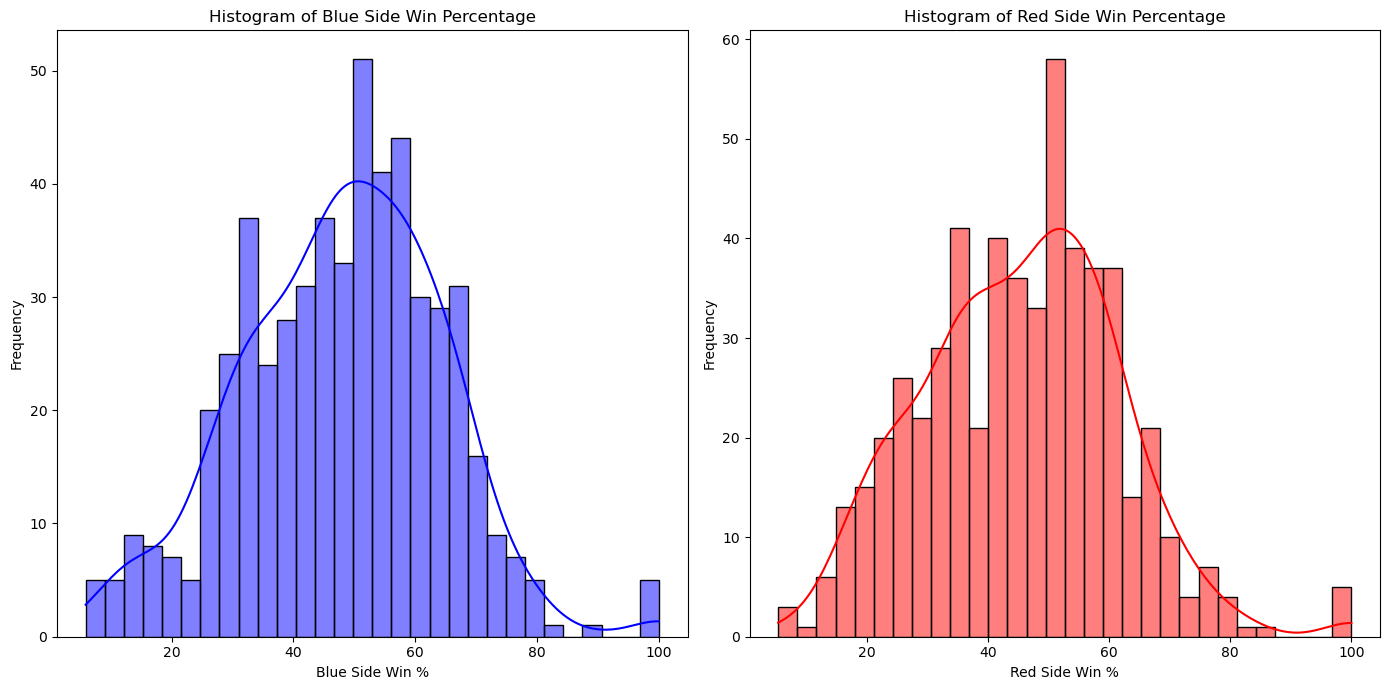

In [6]:
# Plot histograms for win percentages of blue and red sides
plt.figure(figsize=(14, 7))

# Histogram for Blue Side Win Percentage
plt.subplot(1, 2, 1)
sns.histplot(win_percentages_with_names_filtered['Blue Side Win %'], bins=30, color='blue', kde=True)
plt.title('Histogram of Blue Side Win Percentage')
plt.xlabel('Blue Side Win %')
plt.ylabel('Frequency')

# Histogram for Red Side Win Percentage
plt.subplot(1, 2, 2)
sns.histplot(win_percentages_with_names_filtered['Red Side Win %'], bins=30, color='red', kde=True)
plt.title('Histogram of Red Side Win Percentage')
plt.xlabel('Red Side Win %')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We can merge the curves for a better view of the distributions

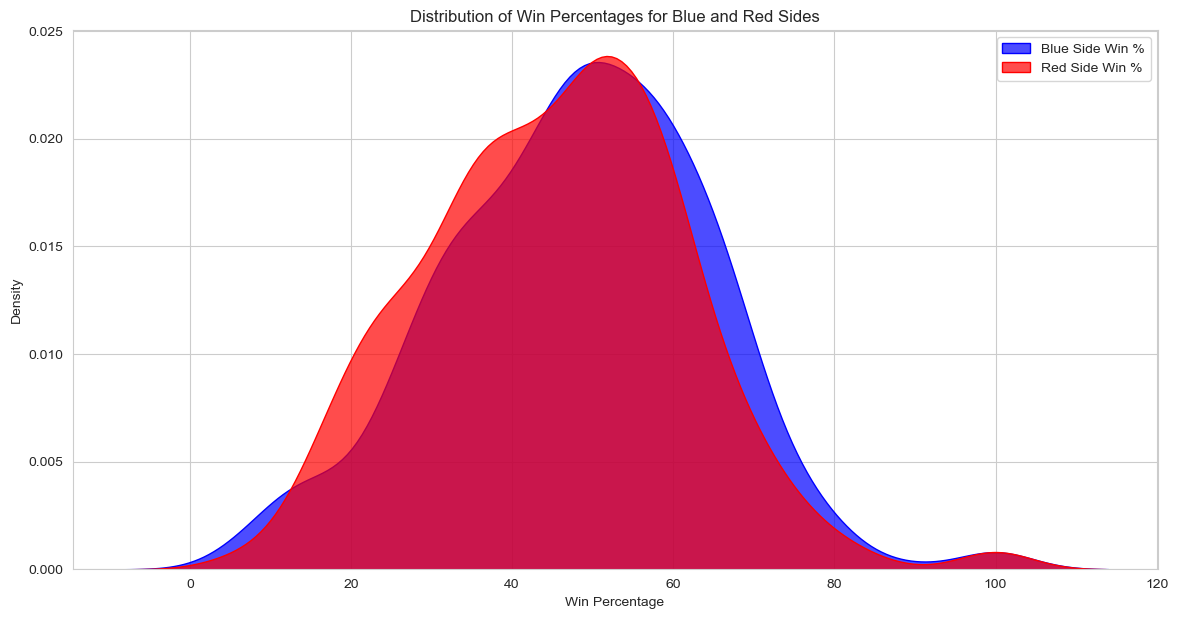

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))


sns.kdeplot(win_percentages_with_names_filtered['Blue Side Win %'], fill=True, color="blue", label="Blue Side Win %", alpha=0.7)
sns.kdeplot(win_percentages_with_names_filtered['Red Side Win %'], fill=True, color="red", label="Red Side Win %", alpha=0.7)

plt.title("Distribution of Win Percentages for Blue and Red Sides")
plt.xlabel("Win Percentage")
plt.ylabel("Density")
plt.legend()

plt.show()

The visualization provides a clearer view of the distributions of win percentages for both the blue and red sides. Here's what we can observe:
- both distributions appear somewhat normally distributed with some skewness.
- the blue side's distribution seems to have a slightly more pronounced peak around the 50% mark compared to the red side, supporting the observation that the blue side has a slightly higher average win percentage.

In [8]:
# quick maffs
blue_favored = win_percentages_with_names_filtered[win_percentages_with_names_filtered['Blue Side Win %'] > win_percentages_with_names_filtered['Red Side Win %']].shape[0]
red_favored = win_percentages_with_names_filtered[win_percentages_with_names_filtered['Red Side Win %'] > win_percentages_with_names_filtered['Blue Side Win %']].shape[0]
equal_performance = win_percentages_with_names_filtered[win_percentages_with_names_filtered['Red Side Win %'] == win_percentages_with_names_filtered['Blue Side Win %']].shape[0]

blue_favored, red_favored, equal_performance

(320, 202, 22)

So roughly 320 teams have a higher win rate on blue, 202 have a higher rate on red, and around 22 teams have balanced 50% win rate on both sides.

We'll use a paired t-test (normalized data assumption) since the data for blue and red sides come from the same teams, and also validate with the Wilcoxon Signed-Rank Test (doesn't rely on the assumption of normal distribution). 

The null hypothesis will be that there is no difference in win percentages between the two sides, while the alternative hypothesis will be that there is a difference.

In [10]:
# Conduct a paired t-test
t_stat, p_value = ttest_rel(win_percentages_with_names_filtered['Blue Side Win %'], win_percentages_with_names_filtered['Red Side Win %'])

t_stat, p_value

(3.8686800345733583, 0.00012270991951739623)

The results of the paired t-test are as follows:
- t-statistic: 3.87
- p-value: 0.00012

Given a commonly used significance level of α=0.05, the p-value of 0.00012 is less than α. This means we can reject the null hypothesis and conclude that there is a statistically significant difference in the win percentages between the blue and red sides.

In [13]:
w_stat, w_p_value = wilcoxon(win_percentages_with_names_filtered['Blue Side Win %'] - win_percentages_with_names_filtered['Red Side Win %'])
w_stat, w_p_value

(50700.0, 3.567801314067761e-07)

The results of the Wilcoxon Signed-Rank Test are as follows:
- Test Statistic: 50700.0
- p-value: 3.57×10^−7

Given a significance level of α=0.05, the p-value is significantly smaller than α. This means we can reject the null hypothesis, suggesting that there is a statistically significant difference in the win percentages between the blue and red sides, even when using a non-parametric test.

Thus, in conclusion based on both the t-test and Wilcoxon Signed-rank test, our hypothesis, that teams, on average, win more on the blue side compared to the red side is supported by the data, and it seems reasonable to consider the side on which a team plays (blue or red) as an influential factor and use as a feature in a machine learning model

## Feature 2: First Tower %

### Problem 1: Understand game data via EDA

Let's first start by reading an individual game data. Let's pick the first file in this case since we're still in the EDA phase for game data.

In [297]:
sample_game_parquet = pd.read_json("../games/ESPORTSTMNT03:3200609.json")
sample_game_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3769 entries, 0 to 3768
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eventTime            3769 non-null   object 
 1   eventType            3769 non-null   object 
 2   platformGameId       3769 non-null   object 
 3   participants         2247 non-null   object 
 4   stageID              3769 non-null   int64  
 5   sequenceIndex        3769 non-null   int64  
 6   gameName             3769 non-null   object 
 7   gameVersion          1 non-null      object 
 8   statsUpdateInterval  1 non-null      float64
 9   playbackID           3769 non-null   int64  
 10  gameTime             3768 non-null   float64
 11  spawnTime            12 non-null     float64
 12  monsterName          12 non-null     object 
 13  gameOver             2246 non-null   float64
 14  teams                2246 non-null   object 
 15  nextDragonSpawnTime  7 non-null      f

In [300]:
sample_game_parquet.columns

Index(['eventTime', 'eventType', 'platformGameId', 'participants', 'stageID',
       'sequenceIndex', 'gameName', 'gameVersion', 'statsUpdateInterval',
       'playbackID', 'gameTime', 'spawnTime', 'monsterName', 'gameOver',
       'teams', 'nextDragonSpawnTime', 'nextDragonName', 'itemID',
       'participantID', 'goldGain', 'itemBeforeUndo', 'itemAfterUndo',
       'skillSlot', 'participant', 'evolved', 'wardType', 'position', 'placer',
       'maxCooldown', 'chargesRemaining', 'summonerSpellName', 'maxCharges',
       'maxRechargeTime', 'summonerSpellSlot', 'victimTeamID', 'victim',
       'killer', 'shutdownBounty', 'killStreakLength', 'bounty', 'assistants',
       'killerTeamID', 'killType', 'localGold', 'globalGold', 'bountyGold',
       'monsterType', 'killerGold', 'inEnemyJungle', 'level', 'dragonType',
       'lastHitter', 'teamID', 'lane', 'buildingType', 'turretTier',
       'itemsAdded', 'actualStartTime', 'wallTime', 'winningTeam'],
      dtype='object')

We have 3336 rows and 52 columns, each capturing various aspects of the game, such as events, participants, and game statistics. There's also a lot of columns with missing data, so we will have to dig in further to see, which data is consistently available across all games and which aren't. 

In [301]:
sample_game_parquet.head()

,eventTime,eventType,platformGameId,participants,stageID,sequenceIndex,gameName,gameVersion,statsUpdateInterval,playbackID,gameTime,spawnTime,monsterName,gameOver,teams,nextDragonSpawnTime,nextDragonName,itemID,participantID,goldGain,itemBeforeUndo,itemAfterUndo,skillSlot,participant,evolved,wardType,position,placer,maxCooldown,chargesRemaining,summonerSpellName,maxCharges,maxRechargeTime,summonerSpellSlot,victimTeamID,victim,killer,shutdownBounty,killStreakLength,bounty,assistants,killerTeamID,killType,localGold,globalGold,bountyGold,monsterType,killerGold,inEnemyJungle,level,dragonType,lastHitter,teamID,lane,buildingType,turretTier,itemsAdded,actualStartTime,wallTime,winningTeam
0,2023-08-06T19:09:59.023Z,game_info,ESPORTSTMNT03:3200609,"[{'keystoneID': 8010, 'hashedIP': '3VoTUXLOxMy...",1,0,110733838936512556|game1,13.13.521.1071,1000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-06T19:09:59.023Z,queued_epic_monster_info,ESPORTSTMNT03:3200609,NaN,1,1,110733838936512556|game1,NaN,NaN,1,0.0,1200.0,Baron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-08-06T19:09:59.023Z,queued_epic_monster_info,ESPORTSTMNT03:3200609,NaN,1,2,110733838936512556|game1,NaN,NaN,1,0.0,480.0,RiftHerald,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-08-06T19:10:59.819Z,stats_update,ESPORTSTMNT03:3200609,"[{'ability4CooldownRemaining': 0, 'magicPenetr...",1,14,110733838936512556|game1,NaN,NaN,1,93.0,NaN,NaN,0.0,"[{'inhibKills': 0, 'towerKills': 0, 'teamID': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-08-06T19:10:59.852Z,queued_dragon_info,ESPORTSTMNT03:3200609,NaN,1,15,110733838936512556|game1,NaN,NaN,1,126.0,NaN,NaN,NaN,NaN,300.0,fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [299]:
sample_game_parquet.tail()

,eventTime,eventType,platformGameId,participants,stageID,sequenceIndex,gameName,gameVersion,statsUpdateInterval,playbackID,gameTime,spawnTime,monsterName,gameOver,teams,nextDragonSpawnTime,nextDragonName,itemID,participantID,goldGain,itemBeforeUndo,itemAfterUndo,skillSlot,participant,evolved,wardType,position,placer,maxCooldown,chargesRemaining,summonerSpellName,maxCharges,maxRechargeTime,summonerSpellSlot,victimTeamID,victim,killer,shutdownBounty,killStreakLength,bounty,assistants,killerTeamID,killType,localGold,globalGold,bountyGold,monsterType,killerGold,inEnemyJungle,level,dragonType,lastHitter,teamID,lane,buildingType,turretTier,itemsAdded,actualStartTime,wallTime,winningTeam
3764,2023-08-06T19:49:24.325Z,stats_update,ESPORTSTMNT03:3200609,[{'ability4CooldownRemaining': 17.268310546875...,1,7109,110733838936512556|game1,NaN,NaN,1,2242024.0,NaN,NaN,0.0,"[{'inhibKills': 1, 'towerKills': 7, 'teamID': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3765,2023-08-06T19:49:25.325Z,stats_update,ESPORTSTMNT03:3200609,"[{'ability4CooldownRemaining': 16.26806640625,...",1,7110,110733838936512556|game1,NaN,NaN,1,2243024.0,NaN,NaN,0.0,"[{'inhibKills': 1, 'towerKills': 7, 'teamID': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3766,2023-08-06T19:49:26.327Z,stats_update,ESPORTSTMNT03:3200609,"[{'ability4CooldownRemaining': 15.2666015625, ...",1,7111,110733838936512556|game1,NaN,NaN,1,2244026.0,NaN,NaN,0.0,"[{'inhibKills': 1, 'towerKills': 7, 'teamID': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3767,2023-08-06T19:49:27.166Z,stats_update,ESPORTSTMNT03:3200609,"[{'ability4CooldownRemaining': 14.4306640625, ...",1,7112,110733838936512556|game1,NaN,NaN,1,2244861.0,NaN,NaN,1.0,"[{'inhibKills': 1, 'towerKills': 7, 'teamID': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3768,2023-08-06T19:49:27.167Z,game_end,ESPORTSTMNT03:3200609,NaN,1,7113,110733838936512556|game1,NaN,NaN,1,2244861.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.691351e+12,100.0


Given the tail ends with a `game_end` event type, we can assume that the structure of each game starts with some kind of beginning marker, and ends with this game-end marker.

In [298]:
event_type_distribution = sample_game_parquet['eventType'].value_counts()
event_type_distribution

eventType
stats_update                 2246
item_purchased                291
item_destroyed                232
ward_placed                   207
skill_level_up                166
champion_level_up             156
summoner_spell_used           121
epic_monster_kill             109
ward_killed                   101
champion_kill                  51
item_sold                      14
champion_kill_special          13
building_destroyed             13
queued_epic_monster_info       12
item_undo                      10
turret_plate_destroyed          7
queued_dragon_info              7
epic_monster_spawn              6
turret_plate_gold_earned        4
objective_bounty_prestart       1
game_info                       1
game_end                        1
Name: count, dtype: int64

The majority event-type is `status_update`. Based on these events, we can start focus on our main event we are concerned with (First Tower destruction), while also keeping an eye on other events that we could potentially count as features.

It is also vital to note that for certain event types, we have some kind of participants data that contains nested information about the players in the game, including keystones, champions played, and other potential attributes.

We also notice a whole bunch of missing values in the game-data. We will also need to determine which columns will be relevant and should optimize for either ones we have the most amount of data for, or ones we can fill missing data for.

In [302]:
# Identify all eventTypes where participants data is present
event_types_with_participants = sample_game_parquet[sample_game_parquet['participants'].notnull()]['eventType'].unique()
event_types_with_participants

array(['game_info', 'stats_update'], dtype=object)

The good news is that only `game_info` and `stats_update` event types seem to contain participants data!

There's only 1 `game_info` event per game and 1948 instances of `stats_update` in this game, it would be wise to identify if there's a discrepancy between the structure of the participants info for both the event types.

To find out what kind of columns and info the participants data contains for the two event types, let's dive further and explode the data one by one.

In [303]:
# examing game_info participant data first
ROLES = ["top", "jng", "mid", "adc", "sup", "top", "jng", "mid", "adc", "sup"]
participant_game_info_data = sample_game_parquet[sample_game_parquet['eventType'] == 'game_info']['participants'].explode()
# convert the series of lists to a DataFrame
participant_game_info_data_df = pd.DataFrame(participant_game_info_data.tolist())

# # # show the first few rows of the DataFrame to understand the structure
# participant_game_info_data_df
aha = zip(participant_game_info_data, ROLES)
for player, role in aha:
    print(player['summonerName'], player['teamID'], player['championName'], player['participantID'])


WU Denathor 100 Renekton 1
WU Trixter 100 Maokai 2
WU Sword 100 Tristana 3
WU Mobility 100 Ezreal 4
WU Chookies 100 Leona 5
LIT Dragoon 200 Jax 6
LIT Kisno 200 XinZhao 7
LIT Messages 200 Vex 8
APR ROCKBOOM 200 Xayah 9
LIT Plux 200 Rakan 10


In [49]:
participant_game_info_data_df.columns.unique()

Index(['keystoneID', 'hashedIP', 'teamID', 'participantID', 'championName',
       'accountID', 'abGroup', 'perks', 'summonerName', 'summonerLevel'],
      dtype='object')

### Participants within stats-update

In [304]:
# examine 'stats_update'
stats_update_data = sample_game_parquet[sample_game_parquet['eventType'] == 'stats_update']
stats_update_data.head()
# participants = stats_update_data.iloc[900]['gameTime']
# participants
# participants_df = pd.DataFrame(participants)
# print(participant_stats_update_data_df.shape[0])
# participants_df

900


In [315]:
with open('../games/ESPORTSTMNT03:3200609.json', 'r') as file:
    game_data = json.load(file)


# Extract relevant event data where eventType is "stats_update" and gameTime is 900 seconds (after conversion from milliseconds)

stats_update_900 = [event for event in game_data if event['eventType'] == 'stats_update' and (int(event["gameTime"]) // 1000) == 900]



# Extracting 'assist' information for participant 2 (index 1) from the 'participants' column and nested 'goldStats' column

assist_info_available_stats = False

assist_info_stats = None

if stats_update_900 and 'participants' in stats_update_900[0]:

    participants_stats = stats_update_900[0]['participants']

    if len(participants_stats) > 1 and 'goldStats' in participants_stats[1] and 'assists' in participants_stats[1]['goldStats']:

        assist_info_available_stats = True

        assist_info_stats = participants_stats[1]['goldStats']['assists']



(len(stats_update_900), assist_info_available_stats, assist_info_stats)
print(stats_update_900[0]['participants'][1]['goldStats'])

{'assist': 227, 'ambient': 1611, 'killNeutralMinion': 1832, 'killMinion': 196, 'starting': 500, 'misc': 237}


#### Gold Stats within participants in stats-update

In [291]:
print(participants_df['goldStats'].shape)
participant_gold_stats = participants_df['goldStats']
participant_gold_stats_df = pd.DataFrame(participant_gold_stats.tolist())
participant_gold_stats_df

KeyError: 'goldStats'

#### Stats within participants in stats-update

In [269]:
print(participants_df['stats'].shape)
participant_stats = participants_df['stats'].explode()
participant_stats[1].tolist()
# stats_df = pd.DataFrame(participant_stats.tolist())
# stats_df.head(56)
# test = stats_df.tolist()
# test[0]

(10,)


[{'value': 36, 'name': 'MINIONS_KILLED'},
 {'value': 154.79994201660156, 'name': 'NEUTRAL_MINIONS_KILLED'},
 {'value': 102.3000259399414, 'name': 'NEUTRAL_MINIONS_KILLED_YOUR_JUNGLE'},
 {'value': 8, 'name': 'NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE'},
 {'value': 4, 'name': 'CHAMPIONS_KILLED'},
 {'value': 5, 'name': 'NUM_DEATHS'},
 {'value': 13, 'name': 'ASSISTS'},
 {'value': 8369, 'name': 'PERK0'},
 {'value': 1210.113525390625, 'name': 'PERK0_VAR1'},
 {'value': 1181.0963134765625, 'name': 'PERK0_VAR2'},
 {'value': 0, 'name': 'PERK0_VAR3'},
 {'value': 8304, 'name': 'PERK1'},
 {'value': 10, 'name': 'PERK1_VAR1'},
 {'value': 3, 'name': 'PERK1_VAR2'},
 {'value': 0, 'name': 'PERK1_VAR3'},
 {'value': 8321, 'name': 'PERK2'},
 {'value': 3, 'name': 'PERK2_VAR1'},
 {'value': 0, 'name': 'PERK2_VAR2'},
 {'value': 0, 'name': 'PERK2_VAR3'},
 {'value': 8347, 'name': 'PERK3'},
 {'value': 0, 'name': 'PERK3_VAR1'},
 {'value': 0, 'name': 'PERK3_VAR2'},
 {'value': 0, 'name': 'PERK3_VAR3'},
 {'value': 8126, 'na

### Teams in stats-update

In [270]:
teams = stats_update_data.iloc[-1]['teams']
teams_data_df = pd.DataFrame(teams)
teams_data_df.head()

,inhibKills,towerKills,teamID,baronKills,assists,dragonKills,totalGold,championsKills,deaths
0,1,7,100,2,64,4,74040,28,23
1,0,3,200,0,45,2,66450,23,28


In [53]:
participant_stats_update_data_df.columns.unique()

Index(['ability4CooldownRemaining', 'magicPenetrationPercent', 'alive',
       'participantID', 'spellVamp', 'primaryAbilityResource', 'lifeSteal',
       'primaryAbilityResourceRegen', 'ability1CooldownRemaining',
       'XPForNextLevel', 'summonerSpell2CooldownRemaining', 'healthMax',
       'magicResist', 'ability3CooldownRemaining', 'ability3Level',
       'ability2CooldownRemaining', 'summonerSpell1Name', 'teamID',
       'currentGold', 'healthRegen', 'ability4Level', 'level', 'ability1Level',
       'armorPenetration', 'accountID', 'health', 'ability2Level',
       'ultimateName', 'summonerSpell2Name', 'cooldownReduction', 'goldStats',
       'magicPenetrationPercentBonus', 'magicPenetration', 'position',
       'primaryAbilityResourceMax', 'armorPenetrationPercentBonus',
       'armorPenetrationPercent', 'ability2Name', 'attackDamage',
       'ability3Name', 'championName', 'ccReduction', 'shutdownValue',
       'playerName', 'respawnTimer', 'attackSpeed', 'XP',
       'ultimate

We've verified that the participants structure in a game's data does not change, just the values over the period of the game. This paints a good picture of how we can extract data moving forward for other features. In the mean time, we can now look into the specific features we want for our team — in our case, the team to destroy the first tower.

The process will be to read each game file
- for every game file, check game_info
- find out teams playing
- check building_destroyed column
- sort by timestamp
- find team which destroyed it

In [68]:
# Sort the 'building_destroyed' events by 'eventTime'
buildings_destroyed = sample_game_parquet[sample_game_parquet['eventType'] == 'building_destroyed'].sort_values(by='eventTime')
buildings_destroyed_data = buildings_destroyed.squeeze()
buildings_destroyed_data.shape[0]

19

In [69]:
buildings_destroyed

,eventTime,eventType,platformGameId,participants,stageID,sequenceIndex,gameName,gameVersion,statsUpdateInterval,playbackID,gameTime,spawnTime,monsterName,nextDragonSpawnTime,nextDragonName,gameOver,teams,itemID,participantID,wardType,position,placer,skillSlot,participant,evolved,killer,bountyGold,killType,assistants,monsterType,inEnemyJungle,killerTeamID,level,victimTeamID,victim,shutdownBounty,killStreakLength,bounty,goldGain,itemBeforeUndo,dragonType,lastHitter,teamID,lane,itemsAdded,buildingType,turretTier,itemAfterUndo,wallTime,winningTeam
1549,2022-11-06T04:56:51.371Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,2688,108998961199895792|game5,NaN,NaN,1,864085.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 4505, 'x': 13866}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,200.0,bot,NaN,turret,outer,NaN,NaN,NaN
1803,2022-11-06T04:59:15.735Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,3194,108998961199895792|game5,NaN,NaN,1,1008447.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 13875, 'x': 4318}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,[2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,200.0,top,NaN,turret,outer,NaN,NaN,NaN
2125,2022-11-06T05:02:13.297Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,3856,108998961199895792|game5,NaN,NaN,1,1186001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 8510, 'x': 8955}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,"[2, 3, 4, 5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,200.0,mid,NaN,turret,outer,NaN,NaN,NaN
2360,2022-11-06T05:04:19.305Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,4335,108998961199895792|game5,NaN,NaN,1,1312008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 10441, 'x': 981}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,100.0,top,NaN,turret,outer,NaN,NaN,NaN
2379,2022-11-06T05:04:30.660Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,4375,108998961199895792|game5,NaN,NaN,1,1323367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 8226, 'x': 13327}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,"[1, 4, 5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,bot,NaN,turret,inner,NaN,NaN,NaN
2397,2022-11-06T05:04:41.036Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,4415,108998961199895792|game5,NaN,NaN,1,1333744.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 10572, 'x': 13624}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,"[1, 2, 4]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,200.0,bot,NaN,turret,base,NaN,NaN,NaN
2406,2022-11-06T05:04:46.377Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,4433,108998961199895792|game5,NaN,NaN,1,1339084.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 11316, 'x': 13598}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 4, 5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,bot,NaN,inhibitor,NaN,NaN,NaN,NaN
2408,2022-11-06T05:04:47.345Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,4437,108998961199895792|game5,NaN,NaN,1,1340053.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 6699, 'x': 1512}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,100.0,top,NaN,turret,inner,NaN,NaN,NaN
2649,2022-11-06T05:06:46.712Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,4893,108998961199895792|game5,NaN,NaN,1,1459417.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 13411, 'x': 7943}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,200.0,top,NaN,turret,inner,NaN,NaN,NaN
2658,2022-11-06T05:06:51.207Z,building_destroyed,ESPORTSTMNT02:3080905,NaN,1,4909,108998961199895792|game5,NaN,NaN,1,1463912.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 1029, 'x': 10504}",NaN,NaN,NaN,NaN,NaN,0.0,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,100.0,bot,NaN,turret,outer,NaN,NaN,NaN


## Feature 3: First Blood %

In [296]:
# Sort the 'building_destroyed' events by 'eventTime'
champions_killed = sample_game_parquet[sample_game_parquet['eventType'] == 'champion_kill'].sort_values(by='eventTime')
champions_killed = champions_killed.squeeze()
champions_killed

,eventTime,eventType,platformGameId,participants,stageID,sequenceIndex,gameName,gameVersion,statsUpdateInterval,playbackID,gameTime,spawnTime,monsterName,nextDragonSpawnTime,nextDragonName,gameOver,teams,itemID,participantID,skillSlot,participant,evolved,wardType,position,placer,killer,bountyGold,killType,assistants,monsterType,inEnemyJungle,killerTeamID,level,maxCooldown,summonerSpellName,summonerSpellSlot,victimTeamID,victim,shutdownBounty,killStreakLength,bounty,dragonType,lastHitter,teamID,lane,buildingType,turretTier,actualStartTime,goldGain,itemBeforeUndo,wallTime,winningTeam
238,2023-01-21T21:10:39.474Z,champion_kill,ESPORTSTMNT01:3294091,None,1,347,109518697661991477|game1,None,NaN,1,141192.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 13293.0, 'z': 2734.0}",NaN,4.0,NaN,None,[5],None,NaN,100.0,NaN,NaN,None,NaN,200.0,9.0,0.0,0.0,400.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
953,2023-01-21T21:17:43.936Z,champion_kill,ESPORTSTMNT01:3294091,None,1,1743,109518697661991477|game1,None,NaN,1,565655.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 6232.0, 'z': 5824.0}",NaN,7.0,NaN,None,[8],None,NaN,200.0,NaN,NaN,None,NaN,100.0,3.0,0.0,0.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
1313,2023-01-21T21:21:15.024Z,champion_kill,ESPORTSTMNT01:3294091,None,1,2491,109518697661991477|game1,None,NaN,1,776740.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 3951.0, 'z': 12740.0}",NaN,1.0,NaN,None,[],None,NaN,100.0,NaN,NaN,None,NaN,200.0,6.0,0.0,0.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
1766,2023-01-21T21:25:31.026Z,champion_kill,ESPORTSTMNT01:3294091,None,1,3352,109518697661991477|game1,None,NaN,1,1032741.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 10046.0, 'z': 6812.0}",NaN,7.0,NaN,None,"[8, 10]",None,NaN,200.0,NaN,NaN,None,NaN,100.0,5.0,0.0,1.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
2283,2023-01-21T21:30:37.628Z,champion_kill,ESPORTSTMNT01:3294091,None,1,4391,109518697661991477|game1,None,NaN,1,1339341.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 9472.0, 'z': 9863.0}",NaN,4.0,NaN,None,[5],None,NaN,100.0,NaN,NaN,None,NaN,200.0,10.0,0.0,1.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
2383,2023-01-21T21:31:39.409Z,champion_kill,ESPORTSTMNT01:3294091,None,1,4586,109518697661991477|game1,None,NaN,1,1401121.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 7179.0, 'z': 6685.0}",NaN,10.0,NaN,None,[8],None,NaN,200.0,NaN,NaN,None,NaN,100.0,4.0,350.0,0.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
2450,2023-01-21T21:32:21.294Z,champion_kill,ESPORTSTMNT01:3294091,None,1,4765,109518697661991477|game1,None,NaN,1,1443005.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 5931.0, 'z': 13302.0}",NaN,3.0,NaN,None,[],None,NaN,100.0,NaN,NaN,None,NaN,200.0,8.0,0.0,0.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
2463,2023-01-21T21:32:27.430Z,champion_kill,ESPORTSTMNT01:3294091,None,1,4797,109518697661991477|game1,None,NaN,1,1449139.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 5730.0, 'z': 14100.0}",NaN,7.0,NaN,None,"[8, 9, 10]",None,NaN,200.0,NaN,NaN,None,NaN,100.0,3.0,150.0,2.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
3003,2023-01-21T21:37:34.306Z,champion_kill,ESPORTSTMNT01:3294091,None,1,5891,109518697661991477|game1,None,NaN,1,1756013.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 9468.0, 'z': 5822.0}",NaN,3.0,NaN,None,"[1, 4]",None,NaN,100.0,NaN,NaN,None,NaN,200.0,9.0,0.0,0.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN
3011,2023-01-21T21:37:38.745Z,champion_kill,ESPORTSTMNT01:3294091,None,1,5915,109518697661991477|game1,None,NaN,1,1760452.0,NaN,None,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,"{'x': 8701.0, 'z': 5555.0}",NaN,8.0,NaN,None,"[7, 9, 10]",None,NaN,200.0,NaN,NaN,None,NaN,100.0,2.0,0.0,0.0,300.0,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN


## Feature 4: First dragon %

TBD

In [63]:
epic_monsters_killed = sample_game_parquet[sample_game_parquet['eventType'] == 'epic_monster_kill'].sort_values(by='eventTime')
epic_monsters_killed = epic_monsters_killed.squeeze()
# epic_monsters_killed
dragons_killed = epic_monsters_killed[epic_monsters_killed['monsterType'] == 'dragon'].sort_values(by='eventTime')
dragons_killed

,eventTime,eventType,platformGameId,participants,stageID,sequenceIndex,gameName,gameVersion,statsUpdateInterval,playbackID,gameTime,spawnTime,monsterName,nextDragonSpawnTime,nextDragonName,gameOver,teams,itemID,participantID,skillSlot,participant,evolved,goldGain,itemBeforeUndo,wardType,position,placer,killer,bountyGold,killType,assistants,monsterType,inEnemyJungle,killerTeamID,level,victimTeamID,victim,shutdownBounty,killStreakLength,bounty,dragonType,lastHitter,teamID,lane,itemsAdded,buildingType,turretTier,actualStartTime,wallTime,winningTeam
693,2022-10-24T01:40:19.786Z,epic_monster_kill,ESPORTSTMNT02:3048787,NaN,1,1190,108998961199830238|game5,NaN,NaN,1,430142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 4662, 'x': 10125}",NaN,2.0,0.0,kill,"[4, 5]",dragon,0.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1328,2022-10-24T01:46:19.987Z,epic_monster_kill,ESPORTSTMNT02:3048787,NaN,1,2388,108998961199830238|game5,NaN,NaN,1,790341.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 4718, 'x': 10048}",NaN,7.0,0.0,kill,[10],dragon,0.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,hextech,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2055,2022-10-24T01:53:09.353Z,epic_monster_kill,ESPORTSTMNT02:3048787,NaN,1,3911,108998961199830238|game5,NaN,NaN,1,1199702.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 4416, 'x': 9866}",NaN,7.0,0.0,kill,[10],dragon,0.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2681,2022-10-24T01:59:24.103Z,epic_monster_kill,ESPORTSTMNT02:3048787,NaN,1,5337,108998961199830238|game5,NaN,NaN,1,1574443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 4733, 'x': 10268}",NaN,1.0,500.0,kill,"[2, 3, 4, 5]",dragon,0.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3240,2022-10-24T02:04:34.910Z,epic_monster_kill,ESPORTSTMNT02:3048787,NaN,1,6673,108998961199830238|game5,NaN,NaN,1,1885247.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 4414, 'x': 9866}",NaN,7.0,0.0,kill,[9],dragon,0.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3753,2022-10-24T02:09:59.973Z,epic_monster_kill,ESPORTSTMNT02:3048787,NaN,1,7860,108998961199830238|game5,NaN,NaN,1,2210299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'z': 4414, 'x': 9866}",NaN,7.0,0.0,steal,"[1, 2, 3, 4, 5, 9, 10, 9, 10]",dragon,0.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
oracles_data = pd.read_csv("../esports-data/lol-esports-data/2023_LoL_OE_data.csv")
oracles_data.head(15)

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,side,position,playername,playerid,teamname,teamid,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,chemtechs,hextechs,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,1,Blue,top,Wylenz,oe:player:60aff1184bec1d2b2efdae84f5b6e3e,Klanik Esport,oe:team:0ade5e44c23039bca133eee58ec1b83,Jax,Sylas,Caitlyn,Wukong,Akali,Yone,2612,1,4,0,6,13,7,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2986,0.4594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,14283,328.0934,0.150027,719.5406,878.9127,20,0.4594,5,0.1149,11,49,1.1256,18855,13251,304.3874,0.295868,15955,NaN,399.0,367.0,32,NaN,NaN,9.1654,3163.0,4772.0,83.0,3087.0,4814.0,81.0,76.0,-42.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5059.0,7946.0,143.0,4737.0,7683.0,131.0,322.0,263.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,2,Blue,jng,Julbu,oe:player:fd78e127e45463dcfc2ea3836af0335,Klanik Esport,oe:team:0ade5e44c23039bca133eee58ec1b83,Poppy,Sylas,Caitlyn,Wukong,Akali,Yone,2612,1,2,2,4,13,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2986,0.4594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6219,142.8560,0.065324,847.3047,1513.9663,18,0.4135,11,0.2527,17,61,1.4012,12082,6478,148.8055,0.144640,11675,NaN,159.0,23.0,136,NaN,NaN,3.6524,3035.0,3302.0,54.0,2948.0,3140.0,66.0,87.0,162.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,4325.0,4637.0,74.0,4682.0,5960.0,117.0,-357.0,-1323.0,-43.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,3,Blue,mid,Sintax,oe:player:baf7147fedeec5de54ca1f240952a3f,Klanik Esport,oe:team:0ade5e44c23039bca133eee58ec1b83,Taliyah,Sylas,Caitlyn,Wukong,Akali,Yone,2612,1,2,2,11,13,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2986,0.4594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,27028,620.8576,0.283899,365.3522,323.7289,23,0.5283,10,0.2297,7,49,1.1256,15722,10118,232.4196,0.225914,14525,NaN,337.0,287.0,50,NaN,NaN,7.7412,3117.0,4927.0,85.0,3455.0,5174.0,103.0,-338.0,-247.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0,4956.0,7772.0,136.0,5435.0,8096.0,162.0,-479.0,-324.0,-26.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,4,Blue,bot,Axelent,oe:player:8204ca38dc1c42012b5d53131271eb1,Klanik Esport,oe:team:0ade5e44c23039bca133eee58ec1b83,Ezreal,Sylas,Caitlyn,Wukong,Akali,Yone,2612,1,5,1,7,13,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2986,0.4594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,42005,964.8928,0.441215,398.4533,234.3721,17,0.3905,6,0.1378,5,47,1.0796,17332,1172